### Instalando PySpark

In [1]:
!pip3 install pyspark

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Criando Spark Context

In [2]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql.functions import col

In [3]:
spark = SparkContext.getOrCreate()

### Carregando Dataset

In [4]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/data/moviesOnStreamingPlatforms_noOutliers.csv')

In [5]:
sql_context = SQLContext(spark)
movies_no_outliers_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_noOutliers.csv"), header=True, inferSchema= True)

In [6]:
movies_no_outliers_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



### MLFlow

In [7]:
!pip3 install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
!pip3 install mlflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

In [10]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

/home/jonatas-clementino/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Função que será utilizada para plotar a reta de regressão com os valores da nota real vs nota predita pelo algortimo, a fim de comparar e ter uma ajuda visual do desempenho.

In [11]:
import matplotlib.pyplot as plt

def plot_comparission_result(y_true, y_pred):
  plt.scatter(y_true, y_pred)
  range = [y_true.min(), y_pred.max()]
  plt.plot(range, range, 'red')
  plt.xlabel('Nota real')
  plt.ylabel('Nota predita')
  plt.show()

Função que calcula o `RMSE`, `MAE` e `R2`.

In [12]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

/home/jonatas-clementino/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
warnings.filterwarnings("ignore")
np.random.seed(40)

Função responsável por fazer o treinamento e chamar os métodos acima. Aqui utilizamos o mlflow para guardar os valores dos parametros e os resultados do algortimo.

In [14]:
def run_experiment_with_model(model, model_name, train_x, train_y, test_x, test_y, params_dict={}, plot=True):
    # cria um experimento para cada algortimo executado para ajudar na divisão e organização
    experiment_name='MovieIt-'+model_name 
    mlflow.set_experiment(experiment_name=experiment_name)
    with mlflow.start_run():
        model.fit(train_x, train_y)

        predicted_qualities = model.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print(model_name)
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        for param_name, param_value in params_dict.items():
            mlflow.log_param(param_name, param_value)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, model_name, registered_model_name=model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)
        
        if plot:
            plot_comparission_result(test_y, predicted_qualities)

        return r2

### Regressão

Escolhemos a nota do IMDb como target de predição, pelo fato de ser um valor que depende muito do gosto e opinião das pessoas. Por este motivo utilizaremos algoritmos de regressão para prever a nota.

##### Preparação dos dataset para regressão

Salvamos o dataset que foi processado no Projeto 1, porém houveram alguns problemas quando foram salvos com os dados e tivemos que fazer alguns pre processamentos.

In [15]:
from pyspark.sql.functions import split

movies_no_outliers_df = (movies_no_outliers_df.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language')
.drop('_c0'))

In [16]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_no_outliers_df = movies_no_outliers_df.withColumn("Age", translate('Age', '+', ''))
movies_no_outliers_df = movies_no_outliers_df.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

In [17]:
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_no_outliers_df = movies_no_outliers_df.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [18]:
movies_no_outliers_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



**One hot enconding**

Vamos explodir o array de gênero, países e línguas e transformá-los em diversas colunas com valores binários para cada filme e juntar essas novas informações a tabela original.

In [19]:
from pyspark.sql.functions import explode

exploded_genres = movies_no_outliers_df.withColumn('exploded', explode(col('GenresArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_genres.show(5)

+-----+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+
|   ID|Action|Adventure|Animation|Biography|Comedy|Crime|Documentary|Drama|Family|Fantasy|Film-Noir|History|Horror|Music|Musical|Mystery|News|Reality-TV|Romance|Sci-Fi|Short|Sport|Talk-Show|Thriller|War|Western|
+-----+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+
| 3918|     0|        0|        0|        0|     0|    0|          0|    1|     0|      0|        0|      0|     1|    0|      0|      1|   0|         0|      0|     1|    0|    0|        0|       0|  0|      0|
| 3997|     0|        0|        0|        0|     0|    1|          0|    1|     0|      0|        0|      0|     0|    0|      0|      1|   0|         0

In [20]:
exploded_countries = movies_no_outliers_df.withColumn('exploded', explode(col('CountriesArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_countries.show(5)

+----+-----------+-------+-------+---------+---------+-------+-------+-------+----------+-------+-------+-------+----------------------+------+--------+--------+------+--------------+----+-----+-----+--------+-----+----------+-------+----+------+--------------+--------------+-------+------------------+------------+-----+-------+--------+-------+------+-------+-------+-----+------+---------+-----+-----------------------------+---------+-------+-------+-----+---------+----+----+-------+------+-----+-------+-----+------+-----+----------+-------+-------+-----+---------+----------+------+--------+-----+------+------+----------+-------+-------+-----+-----------+-----------+-------+------+--------+---------+------+----------------+--------+----+-----------+------+--------+-----------+-----+---------------------------+-------+------+------+------------+-------+------+---------+--------+--------+------------+-----------+------------+-----+------+-----------+-----+------+--------+--------+------

In [21]:
exploded_languages = movies_no_outliers_df.withColumn('exploded', explode(col('LanguagesArray'))).groupby('ID').pivot('exploded').count().na.fill(0)
exploded_languages.show(5)

+----+------------------+----------+---------+----+--------+---------+----------------------+-------+----------------+------+---------+-------+--------+--------+--------------------+--------------------+------------------------+------+------+-----+-------+----------------+--------+-------+-----------------------+---------+---------+-------+--------+-------+-------+-----+--------+-----+------+----+-----+----------------+-------+---------+--------+---+--------+-------+-------+------+--------------------+-----+--------+--------+------+-----+-------+--------+-------+-----+--------+--------+------+-----+---------+---------+----------+---------+-----+-------+--------+----------------------+------+-------+-----+-----------+-------+-------+------+------+-------+-----+-------+-------+----------+----------+-------------+----------+-----+---------+-------+--------+--------+-----+----------+-------+----+--------------+-------+------+---------+----+------+------+----+---------------------+---------

In [22]:
movies_exploded = movies_no_outliers_df.join(exploded_genres, 'ID')
movies_exploded = movies_exploded.join(exploded_countries,'ID')
movies_exploded = movies_exploded.join(exploded_languages,'ID')
movies_exploded.show(5)

+-----+--------------------+----+----+-------+----+-----------+-------+-------+-----------------+--------------------+--------------------+--------------------+---------------------+--------------+------+---------+---------+---------+------+-----+-----------+-----+------+-------+---------+-------+------+-----+-------+-------+----+----------+-------+------+-----+-----+---------+--------+---+-------+-----------+-------+-------+---------+---------+-------+-------+-------+----------+-------+-------+-------+----------------------+------+--------+--------+------+--------------+----+-----+-----+--------+-----+----------+-------+----+------+--------------+--------------+-------+------------------+------------+-----+-------+--------+-------+------+-------+-------+-----+------+---------+-----+-----------------------------+---------+-------+-------+-----+---------+----+----+-------+------+-----+-------+-----+------+-----+----------+-------+-------+-----+---------+----------+------+--------+-----+

Vamos dropar as colunas que não queremos que participem das regressões e as colunas com os arrays que acabamos de explodir.

In [23]:
movies_data = movies_exploded.toPandas()
movies_data = movies_data.drop(['LanguagesArray', 'CountriesArray', 'DirectorsArray', 'GenresArray', 'ID', 'Title'], axis = 1)
movies_data.head(5)

,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,Action,...,Turkmen,Ukrainian,Urdu,Vietnamese,Welsh,Wolof,Xhosa,Yiddish,Yoruba,Zulu
0,2019,5.9,0,1,0,0,105,-1,6.8,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,6.0,0,1,0,0,101,18,1.8,0,...,0,0,0,0,0,0,0,0,0,0
2,2016,6.9,1,0,0,0,107,18,9.3,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,6.5,1,0,1,0,123,13,6.4,0,...,0,0,0,0,0,0,0,0,0,0
4,1992,4.8,0,0,0,1,89,7,4.0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos separar o dataset com as variaveis independentes e target



In [24]:
X = movies_data.drop('IMDb', axis=1)
y = movies_data['IMDb']

##### Análise de mutual information

Analisaremos agora o mutual information entre as features e target e removeremos todas as features que possuem mutual information de 0.

In [25]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

mi = mutual_info_regression(X, y)
mi = pd.Series(mi)
mi.index = X.columns

df = pd.DataFrame(mi, columns=['mutual_information_score'])
no_mutual_information = df[(df['mutual_information_score'] == 0) | (df['mutual_information_score'] == None)]
no_mutual_information_features = no_mutual_information.index
no_mutual_information_features

Index(['Disney+', 'Adventure', 'Animation', 'Music', 'Reality-TV', 'Sci-Fi',
       'Short', 'Thriller', 'Afghanistan', 'Albania',
       ...
       'Tagalog', 'Tamil', 'Thai', 'Tupi', 'Turkmen', 'Urdu', 'Vietnamese',
       'Welsh', 'Yiddish', 'Yoruba'],
      dtype='object', length=162)

In [26]:
movies_data.shape

(5014, 310)

In [27]:
movies_data_no_mi = movies_data.drop(no_mutual_information_features, axis = 1)
movies_data_no_mi.shape

(5014, 148)

Removemos entao mais de 150 features que não tinha dependência com nosso target (nota IMDb).

In [28]:
movies_data = movies_data_no_mi
X = movies_data.drop('IMDb', axis=1)
y = movies_data['IMDb']

#### Separando dados para treinamento e teste

Fazendo uso da função `train_test_split` do `sklean`, iremos separar o dataset para 1/3 de teste e o resto de treinamento.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [30]:
y_test

4308    6.4
4216    6.6
3230    5.4
2758    7.0
2986    6.6
       ... 
2104    5.7
3428    7.6
2730    6.7
1056    6.9
1726    7.0
Name: IMDb, Length: 1655, dtype: float64

#### Algoritmos

Decidimos utilizar esses regressores, porque pelo que pesquisamos são bastante utilizados e conhecidos. 

- Primeiramente, sobre o Linear Regression, por o R2 estar negativo, podemos interpretar que o modelo não se mostrou eficaz em predizer os valores das notas do IMDB. **Obs: Por causa da separação de dados ser randômica, aconteceram casos de o R2 do Linear Regression ser positivo com valor aproximadamente 0.5.**

- O Decision Tree Regressor de todos os algoritmos é o que possui o R2 mais baixo, mostrando que o modelo não representa tão bem os dados. Além disso a média dos erros absolutos das notas (MAE) quanto a raiz quadrada do erro médio (RMSE) foram os mais altos. Este modelo não parece ser o melhor canditato para predizer a nota.

- Sobre o MLP Regressor e o Random Forest Regressor, apresentaram métricas semelhantes sendo que o Random Forest possui um R2 score maior e menores erros em comparação com o MLP. Logo o Random Forest parece ser o melhor algoritmo para predizer as notas do IMDB com um R2 score de 53%.

##### Linear Regression

LinearRegression
  RMSE: 1465498034.0826197
  MAE: 63208669.33692702
  R2: -2.1387091749756526e+18


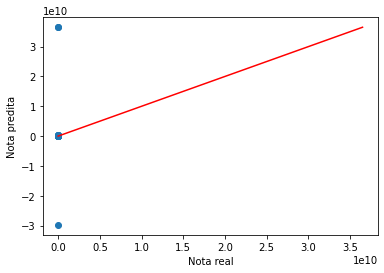

-2.1387091749756526e+18

In [31]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegressionName = 'LinearRegression'

run_experiment_with_model(linearRegression, linearRegressionName, X_train, y_train, X_test, y_test)

##### Decision Tree Regressor

DecisionTreeRegressor
  RMSE: 0.9419142301284279
  MAE: 0.7233836858006043
  R2: 0.1165052595880427


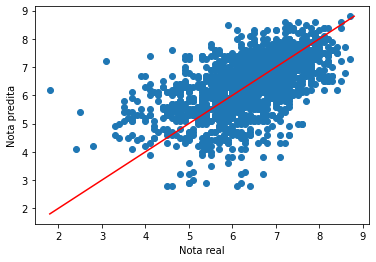

0.1165052595880427

In [32]:
from sklearn.tree import DecisionTreeRegressor

decisionTree = DecisionTreeRegressor()
decisionTreeName = 'DecisionTreeRegressor'

run_experiment_with_model(decisionTree, decisionTreeName, X_train, y_train, X_test, y_test)

##### MLPRegressor

MLPRegressor
  RMSE: 0.7037839022198807
  MAE: 0.5510377417870722
  R2: 0.506758159069715


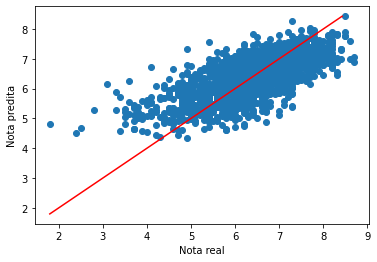

0.506758159069715

In [33]:
from sklearn.neural_network import MLPRegressor

mlpRegressor = MLPRegressor()  
mlpRegressorName = 'MLPRegressor'


run_experiment_with_model(mlpRegressor, mlpRegressorName, X_train, y_train, X_test, y_test)

##### RandomForest

RandomForestRegressor
  RMSE: 0.6835910251868526
  MAE: 0.5212540181268881
  R2: 0.5346561734919467


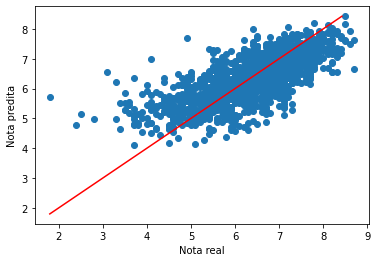

0.5346561734919467

In [34]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor()
randomForestName = 'RandomForestRegressor'


run_experiment_with_model(randomForest, randomForestName, X_train, y_train, X_test, y_test)

### Seleção de Hiper Parâmetros

Para seleção dos hiper parâmetros dos algortimos iremos utilizar a ferramenta `optuna`, ela nos permite escolher os hiper parâmetros assim como seus valores para cada iteração.

In [35]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Hiper parâmetros utilizados:

1. Linear
    * fit intercept
    * normalize
2. MLP
    * função de ativação
    * taxa de aprendizado
    * número de épocas
3.  Decision Tree
    * profundidade max da árvore
    * número de amostras para separar o nó interno
4. Random Forest
    * número de árvores
    * profundidade max da árvore






In [36]:
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['LinearRegression', 'MLPRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor'])
    if regressor_name == 'LinearRegression':
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        normalize = trial.suggest_categorical('normalize', [True, False])
        regressor_obj = LinearRegression(fit_intercept=fit_intercept, normalize=normalize)
    if regressor_name == 'MLPRegressor':
        activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        max_iter = trial.suggest_int('max_iter', 150, 200, step=10)
        regressor_obj = MLPRegressor(activation=activation, learning_rate=learning_rate, max_iter=max_iter)
    if regressor_name == 'DecisionTreeRegressor':
        dt_max_depth = trial.suggest_int('max_depth', 1, 32, step=2)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        regressor_obj = DecisionTreeRegressor(max_depth=dt_max_depth, min_samples_split=min_samples_split)
    if regressor_name == 'RandomForestRegressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        rf_max_depth = trial.suggest_int('max_depth', 1, 32, step=2)
        regressor_obj = RandomForestRegressor(n_estimators=n_estimators, max_depth=rf_max_depth)
        
    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=600)  # Invoke optimization of the objective function.

[I 2020-11-16 23:03:37,709] A new study created in memory with name: no-name-afcb1771-43fe-4c6c-829f-4ebcc6381cec
[I 2020-11-16 23:03:38,072] Trial 0 finished with value: 0.5487921465777612 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 30, 'max_depth': 9}. Best is trial 0 with value: 0.5487921465777612.
[I 2020-11-16 23:03:49,900] Trial 1 finished with value: 0.515229076327334 and parameters: {'regressor': 'MLPRegressor', 'activation': 'logistic', 'learning_rate': 'invscaling', 'max_iter': 160}. Best is trial 0 with value: 0.5487921465777612.
[I 2020-11-16 23:03:49,997] Trial 2 finished with value: -3.216467808053605e+24 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 0.5487921465777612.
[I 2020-11-16 23:03:50,081] Trial 3 finished with value: 0.5008836724365376 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 0.54879

[I 2020-11-16 23:04:34,841] Trial 35 finished with value: 0.5453970027426096 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 60, 'max_depth': 11}. Best is trial 31 with value: 0.5536494226298261.
[I 2020-11-16 23:04:43,629] Trial 36 finished with value: 0.49730138507429156 and parameters: {'regressor': 'MLPRegressor', 'activation': 'tanh', 'learning_rate': 'invscaling', 'max_iter': 200}. Best is trial 31 with value: 0.5536494226298261.
[I 2020-11-16 23:04:43,779] Trial 37 finished with value: -3.216467808053605e+24 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'normalize': True}. Best is trial 31 with value: 0.5536494226298261.
[I 2020-11-16 23:04:44,145] Trial 38 finished with value: 0.46344081117194236 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 40, 'max_depth': 3}. Best is trial 31 with value: 0.5536494226298261.
[I 2020-11-16 23:04:53,884] Trial 39 finished with value: 0.4852703854369411 and parameters: {'

[I 2020-11-16 23:05:39,515] Trial 70 finished with value: 0.5465068139223569 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 11}. Best is trial 46 with value: 0.5539712785839854.
[I 2020-11-16 23:05:41,094] Trial 71 finished with value: 0.5508273721670961 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 70, 'max_depth': 9}. Best is trial 46 with value: 0.5539712785839854.
[I 2020-11-16 23:05:41,617] Trial 72 finished with value: 0.5483551608000491 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 30, 'max_depth': 7}. Best is trial 46 with value: 0.5539712785839854.
[I 2020-11-16 23:05:43,493] Trial 73 finished with value: 0.5386406666021162 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 60, 'max_depth': 13}. Best is trial 46 with value: 0.5539712785839854.
[I 2020-11-16 23:05:45,169] Trial 74 finished with value: 0.55074951641448 and parameters: {'regressor': 'RandomForestRegresso

[I 2020-11-16 23:06:40,971] Trial 106 finished with value: 0.5447711927877104 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:06:43,122] Trial 107 finished with value: 0.5528227850262915 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:06:43,179] Trial 108 finished with value: 0.42094107630337096 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 9, 'min_samples_split': 8}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:06:44,978] Trial 109 finished with value: 0.5450740083036214 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:06:48,465] Trial 110 finished with value: -0.00020190904442607405 and parameters: {'regressor':

[I 2020-11-16 23:07:50,531] Trial 141 finished with value: 0.5509157967086391 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:07:52,672] Trial 142 finished with value: 0.5527827662817755 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:07:54,803] Trial 143 finished with value: 0.5519830401648222 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:07:57,742] Trial 144 finished with value: 0.5491449338627932 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 104 with value: 0.5548677731973758.
[I 2020-11-16 23:08:00,301] Trial 145 finished with value: 0.553755541113269 and parameters: {'regressor': 'RandomF

[I 2020-11-16 23:09:21,788] Trial 176 finished with value: 0.5501800374343446 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:09:23,899] Trial 177 finished with value: 0.5518964260389243 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:09:25,713] Trial 178 finished with value: 0.5486548036054573 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:09:27,472] Trial 179 finished with value: 0.5442155508374942 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:09:29,717] Trial 180 finished with value: 0.5457057702810653 and parameters: {'regressor': 'RandomF

[I 2020-11-16 23:10:43,276] Trial 211 finished with value: 0.5496402660696367 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:10:45,437] Trial 212 finished with value: 0.5529278874528385 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:10:47,578] Trial 213 finished with value: 0.5473177440443373 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:10:49,985] Trial 214 finished with value: 0.5490630153245561 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 171 with value: 0.5549793829555751.
[I 2020-11-16 23:10:51,798] Trial 215 finished with value: 0.5530685692931427 and parameters: {'regressor': 'Random

[I 2020-11-16 23:11:59,679] Trial 246 finished with value: 0.5525612621682561 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:12:02,181] Trial 247 finished with value: 0.5497680116641115 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:12:04,070] Trial 248 finished with value: 0.5445775253283921 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:12:06,264] Trial 249 finished with value: 0.5531892209861833 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:12:20,311] Trial 250 finished with value: 0.49880043914291927 and parameters: {'regressor': 'MLPReg

[I 2020-11-16 23:13:28,622] Trial 281 finished with value: 0.5482276560053606 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 50, 'max_depth': 9}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:13:32,868] Trial 282 finished with value: 0.5033336680384521 and parameters: {'regressor': 'MLPRegressor', 'activation': 'relu', 'learning_rate': 'invscaling', 'max_iter': 160}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:13:34,119] Trial 283 finished with value: 0.5488783427513874 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 50, 'max_depth': 11}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:13:35,319] Trial 284 finished with value: 0.5510624364000081 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 50, 'max_depth': 9}. Best is trial 242 with value: 0.5550293872697112.
[I 2020-11-16 23:13:37,219] Trial 285 finished with value: 0.5465041460944301 and parameters: 

[I 2020-11-16 23:15:09,014] Trial 316 finished with value: 0.5521218098796656 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 294 with value: 0.5556994158635831.
[I 2020-11-16 23:15:10,289] Trial 317 finished with value: 0.5447005955130921 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 50, 'max_depth': 11}. Best is trial 294 with value: 0.5556994158635831.
[I 2020-11-16 23:15:13,284] Trial 318 finished with value: 0.5466755640806011 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 294 with value: 0.5556994158635831.
[I 2020-11-16 23:15:15,881] Trial 319 finished with value: 0.5527530888613693 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 294 with value: 0.5556994158635831.
[I 2020-11-16 23:15:19,518] Trial 320 finished with value: 0.5401188433278362 and parameters: {'regressor': 'Rand

[I 2020-11-16 23:16:22,574] Trial 351 finished with value: 0.553523975715422 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:16:23,878] Trial 352 finished with value: 0.5463368176027791 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 80, 'max_depth': 7}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:16:23,965] Trial 353 finished with value: -2.1387091749756526e+18 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'normalize': False}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:16:25,226] Trial 354 finished with value: 0.5245603348681271 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 5}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:16:26,103] Trial 355 finished with value: 0.548877089660355 and parameters: {'regressor': 'Random

[I 2020-11-16 23:17:18,931] Trial 386 finished with value: 0.5499582194706277 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:17:20,195] Trial 387 finished with value: 0.5484595692133716 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:17:20,653] Trial 388 finished with value: 0.5426278692451577 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 30, 'max_depth': 11}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:17:21,849] Trial 389 finished with value: 0.5517173139559728 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:17:23,071] Trial 390 finished with value: 0.5528584357090569 and parameters: {'regressor': 'RandomFo

[I 2020-11-16 23:17:58,556] Trial 421 finished with value: 0.5536427576828762 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:18:00,185] Trial 422 finished with value: 0.5476842554396495 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 13}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:18:01,595] Trial 423 finished with value: 0.5468982676983343 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:18:02,806] Trial 424 finished with value: 0.5493552448565728 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 344 with value: 0.5558598336362998.
[I 2020-11-16 23:18:04,312] Trial 425 finished with value: 0.5496424710378021 and parameters: {'regressor': 'Rando

[I 2020-11-16 23:18:38,055] Trial 456 finished with value: 0.550284216464449 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:18:39,231] Trial 457 finished with value: 0.5513822116388755 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:18:40,176] Trial 458 finished with value: 0.5453014026305383 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:18:41,228] Trial 459 finished with value: 0.5497109509361515 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:18:42,167] Trial 460 finished with value: 0.5484262691867345 and parameters: {'regressor': 'RandomFor

[I 2020-11-16 23:19:24,657] Trial 491 finished with value: 0.5530556340884998 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:19:26,592] Trial 492 finished with value: 0.5460736717095978 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 17}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:19:27,703] Trial 493 finished with value: 0.55195023974678 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 70, 'max_depth': 11}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:19:27,742] Trial 494 finished with value: 0.40431239642927885 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 9, 'min_samples_split': 5}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:19:28,930] Trial 495 finished with value: 0.5529835756902522 and parameters: {'regressor': 'Rand

[I 2020-11-16 23:20:12,736] Trial 526 finished with value: 0.46584167940086096 and parameters: {'regressor': 'DecisionTreeRegressor', 'max_depth': 7, 'min_samples_split': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:20:13,893] Trial 527 finished with value: 0.5497972076528026 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:20:15,047] Trial 528 finished with value: 0.5502479903204807 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:20:16,089] Trial 529 finished with value: 0.5489236441493923 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:20:17,078] Trial 530 finished with value: 0.5448213319988566 and parameters: {'regressor': 'Rand

[I 2020-11-16 23:20:54,834] Trial 561 finished with value: 0.550596541958857 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:20:55,767] Trial 562 finished with value: 0.5462435230615585 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 7}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:05,903] Trial 563 finished with value: 0.4879637631089533 and parameters: {'regressor': 'MLPRegressor', 'activation': 'identity', 'learning_rate': 'constant', 'max_iter': 200}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:07,187] Trial 564 finished with value: 0.5528122148419167 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 90, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:08,614] Trial 565 finished with value: 0.5506189488312963 and parameters

[I 2020-11-16 23:21:56,314] Trial 596 finished with value: 0.5491137117977847 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 11}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:56,383] Trial 597 finished with value: 0.5008836724365376 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'normalize': False}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:57,822] Trial 598 finished with value: 0.5535760255080561 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.
[I 2020-11-16 23:21:58,983] Trial 599 finished with value: 0.5508669429117113 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 100, 'max_depth': 9}. Best is trial 452 with value: 0.5567668642621098.


Utilizamos um valor de n_trials de 600 pois todas as vezes que rodamos, o algoritmo sempre retornava abaixo de 500, demos uma margem de segurança.

Como podemos ver nos logs do optuna o algortimo que apresentou o melhor desempenho, com um `r2 score` de `0.5567668642621098`, foi o `random forest` com os hiper parâmetros `'n_estimators': 100` e  `max_depth': 9`. Sendo assim, utilizaremos ele para tentar melhorar o score e minimizar o erro.

### Diagnóstico de Regressor

Agora iremos tentar melhorar o modelo ajustando a quantidade de features ordenadas pelo valor de seu mutual information com o target. Iremos iterar de 1 até a quantidade total de features para definir o melhor conjunto de features que predizem melhor o target no modelo retornado pelo optuna. Além disso, vamos reduzir o número de dados de treinamento para 60% do dataset utilizando o algoritmo `random forest` com os hiper parâmentros que foram definidos na etapa anterior.

Para isso, ordenamos todos os mutual information em ordem decrescente, para a cada iteração adicionarmos a próxima feature com maior valor de MI.

In [37]:
with_mutual_information = df[(df['mutual_information_score'] != None) & (df['mutual_information_score'] != 0)]
with_mutual_information = with_mutual_information.sort_values(by='mutual_information_score', ascending=False)
total_features = with_mutual_information.shape[0]
features_ordered = with_mutual_information.index
total_features

147

In [42]:
best_r2 = 0
best_features_number = 1

best_model_ever = RandomForestRegressor(n_estimators=100, max_depth=9)
params = {'n_estimators': 100, 'max_depth': 9}

for i in range(1,total_features+1):
    print('Running trial with', i, 'features')
    movies_data_trial = movies_data.drop(features_ordered[i:], axis = 1)
    X_trial = movies_data_trial.drop('IMDb', axis=1)
    y_trial = movies_data_trial['IMDb']
    
    X_train, X_test, y_train, y_test = train_test_split(X_trial, y_trial, test_size=0.4, random_state=0)

    r2 = run_experiment_with_model(best_model_ever, randomForestName, X_train, y_train, X_test, y_test, params_dict=params, plot=False)
    
    if r2 > best_r2:
        best_r2 = r2
        best_features_number = i    

Running trial with 1 features
RandomForestRegressor
  RMSE: 0.7903209851484867
  MAE: 0.6150528478107631
  R2: 0.3829329683471303
Running trial with 2 features
RandomForestRegressor
  RMSE: 0.77905667770092
  MAE: 0.6083106188521783
  R2: 0.40039751347551633
Running trial with 3 features
RandomForestRegressor
  RMSE: 0.7574861948046685
  MAE: 0.5909216843343685
  R2: 0.4331413728402371
Running trial with 4 features
RandomForestRegressor
  RMSE: 0.7111357536902014
  MAE: 0.5524524049769859
  R2: 0.5003908949200402
Running trial with 5 features
RandomForestRegressor
  RMSE: 0.7128714578480723
  MAE: 0.5525257089597698
  R2: 0.4979490773817956
Running trial with 6 features
RandomForestRegressor
  RMSE: 0.7102486949586072
  MAE: 0.550954060335112
  R2: 0.5016365254694506
Running trial with 7 features
RandomForestRegressor
  RMSE: 0.7116342858110006
  MAE: 0.5513879505594728
  R2: 0.4996901609478561
Running trial with 8 features
RandomForestRegressor
  RMSE: 0.7103707548129201
  MAE: 0.5508

RandomForestRegressor
  RMSE: 0.6744132113000603
  MAE: 0.514584362309589
  R2: 0.5506575440490127
Running trial with 65 features
RandomForestRegressor
  RMSE: 0.6740199410635712
  MAE: 0.5146544993329719
  R2: 0.5511814409349897
Running trial with 66 features
RandomForestRegressor
  RMSE: 0.6745045930883191
  MAE: 0.5153482177671133
  R2: 0.5505357655951741
Running trial with 67 features
RandomForestRegressor
  RMSE: 0.6712219261935024
  MAE: 0.5116869601197541
  R2: 0.5549000087803029
Running trial with 68 features
RandomForestRegressor
  RMSE: 0.6739448685045414
  MAE: 0.514032060557458
  R2: 0.5512814144796714
Running trial with 69 features
RandomForestRegressor
  RMSE: 0.6745652590577911
  MAE: 0.5138264906702261
  R2: 0.5504549109648913
Running trial with 70 features
RandomForestRegressor
  RMSE: 0.6741399465782989
  MAE: 0.5148359222666568
  R2: 0.5510216073938198
Running trial with 71 features
RandomForestRegressor
  RMSE: 0.6741989661590708
  MAE: 0.5144871344525594
  R2: 0.55

RandomForestRegressor
  RMSE: 0.6712122459989902
  MAE: 0.5127102093677629
  R2: 0.5549128469289244
Running trial with 128 features
RandomForestRegressor
  RMSE: 0.6730235147793786
  MAE: 0.5128765459659211
  R2: 0.5525074671122063
Running trial with 129 features
RandomForestRegressor
  RMSE: 0.672474400712525
  MAE: 0.5121031695343014
  R2: 0.5532373798032251
Running trial with 130 features
RandomForestRegressor
  RMSE: 0.6721050729587914
  MAE: 0.5125951911381679
  R2: 0.5537279755038206
Running trial with 131 features
RandomForestRegressor
  RMSE: 0.6721772284793268
  MAE: 0.5127498143379161
  R2: 0.553632149062294
Running trial with 132 features
RandomForestRegressor
  RMSE: 0.6696789847068303
  MAE: 0.5111069566793258
  R2: 0.5569439643848624
Running trial with 133 features
RandomForestRegressor
  RMSE: 0.670314201877075
  MAE: 0.5106638074083066
  R2: 0.5561030531881938
Running trial with 134 features
RandomForestRegressor
  RMSE: 0.6706991979704147
  MAE: 0.5124487567046179
  R2

In [43]:
print(best_r2, best_features_number)

0.5591715264590786 146


Conseguimos obter um `r2 score` um pouquinho melhor com as 146 features com maior mutual information. Além disso houve uma pequena redução nos erros (MAE, RMSE).

#### Conclusão

Apesar de possuir um R2 score não tão alto, o MAE apresenta um erro de aproximadamente 0.5 na nota do IMDB, que para uma valor de 0 a 10, o modelo parece ter representado razoavelmente bem os dados.